# Dynamic Causal Modeling with Variational Bayes 
(Extended with B-matrix, region-specific HRF, model comparison)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

#from scipy.integrate import odeint
from autograd import jacobian
import autograd.numpy as anp
from scipy.optimize import minimize
from itertools import combinations

# speeding up
import jax
import jax.numpy as jnp
from jax import jacfwd, hessian
from jax.experimental.ode import odeint


global NREG

NREG = 2 # change number of regions

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
# --- DCM model functions ---
def u(t):
    return jnp.where((t > 5) & (t < 15), 1.0, 0.0)

def neural_model(x, t, A, B, C):
    return (A + B * u(t)) @ x + C * u(t)

In [9]:
def full_state_derivative(t, state, A, B, C, tau, alpha, e0):
    n_regions = NREG
    x_neural = state[:n_regions]
    x_hemo = state[n_regions:]
    dx = np.zeros_like(state)

    dx_neural = (A + B * u(t)) @ x_neural + C * u(t)
    dx[:n_regions] = dx_neural

    for i in range(n_regions):
        s, f, v, q = x_hemo[i*4:(i+1)*4]
        z = x_neural[i]

        # Clip state variables to avoid math errors
        f = max(f, 1e-4)
        v = max(v, 1e-4)
        tau_i = max(tau[i], 1e-3)
        alpha_i = max(alpha[i], 1e-2)
        e0_i = min(max(e0[i], 1e-5), 0.99)

        ds = z - tau_i * s - f + 1
        df = s
        dv = (f - v**(1/alpha_i)) / tau_i
        dq = (f * (1 - (1 - e0_i)**(1/f)) / e0_i - q * v**(1/alpha_i - 1)) / tau_i

        dx[2 + i*4 : 2 + (i+1)*4] = [ds, df, dv, dq]

    return dx


In [10]:
def bold_signal(state, e0):
    state = np.asarray(state)
    y = np.zeros((state.shape[0], 2))
    for i in range(2):
        s, f, v, q = state[:, 2 + i*4:2 + (i+1)*4].T
        f = np.clip(f, 1e-4, None)
        v = np.clip(v, 1e-4, None)
        e = e0[i]
        y[:, i] = 0.02 * (7*e*(1 - q) + 2*(1 - q/v) - 0.2*(1 - v))
    return y

In [11]:
def simulate_dcm(params, t):
    A = params[0:4].reshape(2,2)
    B = params[4:8].reshape(2,2)
    C = params[8:10]
    tau = np.clip(params[10:12], 0.1, 2.0)
    alpha = np.clip(params[12:14], 0.1, 1.5)
    e0 = np.array([0.34, 0.34])
    x0 = np.zeros(2 + 4*2)

    def ode_func(ti, statei):
        return full_state_derivative(ti, statei, A, B, C, tau, alpha, e0)

    res = solve_ivp(
        fun=ode_func,
        t_span=(t[0], t[-1]),
        y0=x0,
        t_eval=t,
        method='RK45',
        rtol=1e-4,
        atol=1e-6
    )

    if not res.success:
        raise RuntimeError(f"ODE solver failed: {res.message}")

    return bold_signal(res.y.T, e0)


In [12]:
# --- Variational Bayes Inference (Laplace approximation) ---
def vb_infer(y_obs, t, prior_mean=None, prior_var=0.1, noise_var=0.01, n_iter=10):
    dim = 14
    mu_prior = np.zeros(dim) if prior_mean is None else prior_mean
    Lambda_prior = np.eye(dim) / prior_var
    y_obs_flat = y_obs.flatten()

    def free_energy(theta):
        y_pred = simulate_dcm(theta, t).flatten()
        err = y_obs_flat - y_pred
        ll = -0.5 * np.sum(err**2) / noise_var
        delta = theta - mu_prior
        lp = -0.5 * delta.T @ Lambda_prior @ delta
        return -(ll + lp)

    mu = np.zeros(dim)
    for i in range(n_iter):
        g = approx_grad(free_energy, mu)
        H = approx_hessian(free_energy, mu)
        Lambda_post = -H + Lambda_prior
        Sigma_post = np.linalg.inv(Lambda_post)
        mu = mu - Sigma_post @ g

        # Clamp parameters (especially HRF)
        mu[10:12] = np.clip(mu[10:12], 0.1, 2.0)   # tau
        mu[12:14] = np.clip(mu[12:14], 0.1, 1.5)   # alpha

    return mu, Sigma_post


In [13]:
def approx_grad(f, x, eps=1e-5):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x1 = x.copy(); x1[i] += eps
        x2 = x.copy(); x2[i] -= eps
        grad[i] = (f(x1) - f(x2)) / (2 * eps)
    return grad

# def approx_hessian(f, x, eps=1e-5):
#     n = len(x)
#     H = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             x_ij1 = x.copy(); x_ij1[i] += eps; x_ij1[j] += eps
#             x_ij2 = x.copy(); x_ij2[i] += eps; x_ij2[j] -= eps
#             x_ij3 = x.copy(); x_ij3[i] -= eps; x_ij3[j] += eps
#             x_ij4 = x.copy(); x_ij4[i] -= eps; x_ij4[j] -= eps
#             H[i, j] = (f(x_ij1) - f(x_ij2) - f(x_ij3) + f(x_ij4)) / (4 * eps**2)
#     return H

def approx_hessian_diag(f, x, eps=1e-5):
    hess_diag = np.zeros_like(x)
    for i in range(len(x)):
        x1 = x.copy(); x1[i] += eps
        x2 = x.copy(); x2[i] -= eps
        hess_diag[i] = (f(x1) - 2*f(x) + f(x2)) / eps**2
    return np.diag(hess_diag)

In [14]:
# --- Utilities ---
def plot_parameters(mu, Sigma, labels):
    plt.figure(figsize=(10, 5))
    plt.errorbar(range(len(mu)), mu, yerr=np.sqrt(np.diag(Sigma)), fmt='o')
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.ylabel("Posterior Mean")
    plt.title("Variational Bayes Parameter Estimates")
    plt.tight_layout()
    plt.show()

## Attempt

In [15]:
t = np.linspace(0, 30, 300)

In [16]:
true_params = np.array([
        -0.4, 0.2, 0.1, -0.3,
         0.1, 0.0, 0.0, 0.0,
         0.2, 0.1,
         0.98, 0.98,
         0.33, 0.33
    ])

In [17]:
y_clean = simulate_dcm(true_params, t)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


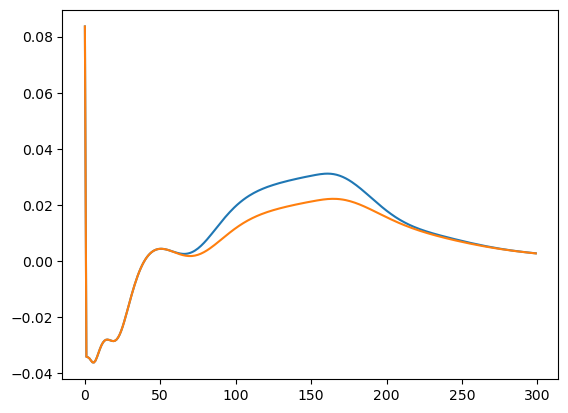

In [18]:
plt.plot(y_clean)

In [19]:
np.random.seed(0)

In [20]:
y_obs = y_clean + 0.01 * np.random.randn(*y_clean.shape)

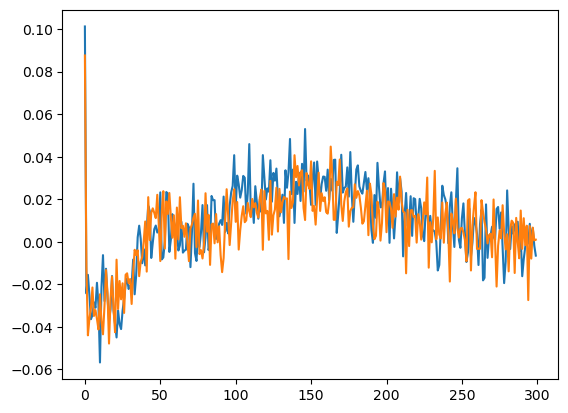

In [21]:
plt.plot(y_obs)

In [22]:
mu_post, Sigma_post = vb_infer(y_obs, t)

/tmp/ipykernel_1333773/2025334116.py:23: RuntimeWarning: overflow encountered in scalar power
  dv = (f - v**(1/alpha_i)) / tau_i
/tmp/ipykernel_1333773/2025334116.py:24: RuntimeWarning: overflow encountered in scalar power
  dq = (f * (1 - (1 - e0_i)**(1/f)) / e0_i - q * v**(1/alpha_i - 1)) / tau_i

KeyboardInterrupt



In [78]:
labels = ['A11', 'A12', 'A21', 'A22','B11','B12','B21','B22','C1','C2','tau1','tau2','alpha1','alpha2']
plot_parameters(mu_post, Sigma_post, labels)


NameError: name 'mu_post' is not defined